# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [2]:
import cv2
import numpy as np
import tensorflow as tf
from keras.applications.densenet import DenseNet201
from keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam

print(tf.__version__)
print(tf.executing_eagerly())

2.6.0
True


## Функции загрузки данных

In [3]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('data/train/*.jpg')
test_files = glob('data/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

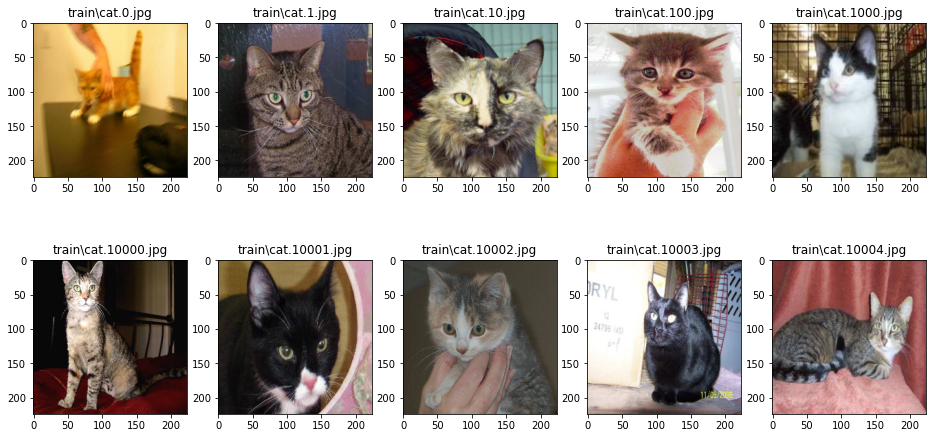

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

Используем DenseNet201.

In [4]:
model = models.Sequential()

model1 = DenseNet201(
            input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3),
            weights = 'imagenet',
            include_top = False
        )

model.add(model1)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1921      
Total params: 18,323,905
Trainable params: 18,094,849
Non-trainable params: 229,056
_________________________________________________________________


## Компилируем модель и запускаем обучение

In [5]:
model.compile(loss='binary_crossentropy',
              optimizer = Adam(learning_rate=1e-5), 
              metrics = ['accuracy'])

In [6]:
val_samples = 100  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=15,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/15
10/10 [==============================] - 158s 15s/step - loss: 0.5788 - accuracy: 0.6875 - val_loss: 0.4236 - val_accuracy: 0.8600
Epoch 2/15
10/10 [==============================] - 141s 14s/step - loss: 0.4242 - accuracy: 0.8750 - val_loss: 0.3065 - val_accuracy: 0.9300
Epoch 3/15
10/10 [==============================] - 141s 14s/step - loss: 0.3054 - accuracy: 0.9406 - val_loss: 0.2224 - val_accuracy: 0.9600
Epoch 4/15
10/10 [==============================] - 147s 15s/step - loss: 0.2418 - accuracy: 0.9594 - val_loss: 0.1642 - val_accuracy: 0.9800
Epoch 5/15
10/10 [==============================] - 141s 14s/step - loss: 0.1742 - accuracy: 0.9812 - val_loss: 0.1279 - val_accuracy: 0.9800
Epoch 6/15
10/10 [==============================] - 138s 14s/step - loss: 0.1635 - accuracy: 0.9656 - val_loss: 0.1050 - val_accuracy: 0.9900
Epoch 7/15
10/10 [==============================] - 138s 14s/step - loss: 0.1518 - accuracy: 0.9625 - val_loss: 0.0877 - val_accuracy: 1.0000
Epoch 

## Предсказания на проверочной выборке

In [7]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

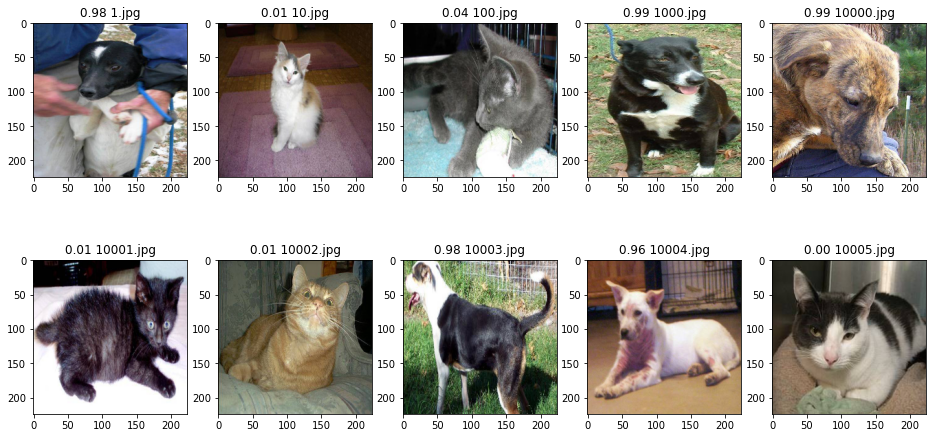

In [8]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [9]:
import re

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

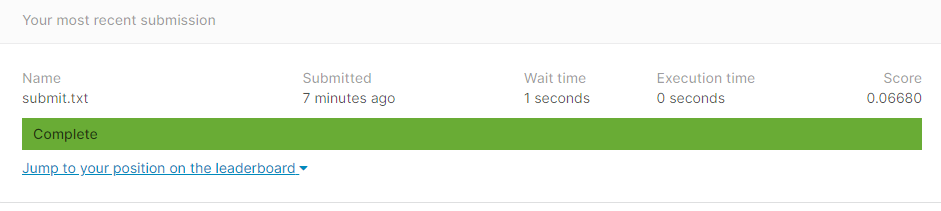